# Property Price Forecasting

This dataset provides information about the median house prices across across various geographies in US
(metropolitan & US geography) in the period from Feb 2008 to October 2024 (monthly data).
For a subset of this period (Jan 2018-Oct 2024) additional information on a market heat index are available. This
index aims at capturing the balance of for-sale supply and demand in a given market (high number means the market
is more tilted in favor of sellers, thus sellers have more power).

In [635]:
# Utility imports and variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-v0_8')

ID_VARS = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']

def separator():
    print('--------------------------------')


def melt_long(df, value_name):
    long_df = df.melt(
        id_vars=ID_VARS,
        var_name='Date',
        value_name=value_name
    )
    long_df['Date'] = pd.to_datetime(long_df['Date'])
    long_df = long_df.sort_values(['RegionName', 'Date'])
    return long_df


## 1. Loading, converting and cleaning the data

In [636]:
# Load the price dataset and take a first look

price = pd.read_csv("Median_sale_price_uc_month.csv")
heat = pd.read_csv("Market_temp_index_uc_month.csv")


### Focus on the price dataset

In [637]:
print(f"price dataset shape: {price.shape}")
separator()

price.info()
separator()

display(price.head(10))


price dataset shape: (713, 206)
--------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Columns: 206 entries, RegionID to 2024-10-31
dtypes: float64(201), int64(2), str(3)
memory usage: 1.1 MB
--------------------------------


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,170922.0,175612.0,177500.0,180000.0,185000.0,...,324000.0,335000.0,345000.0,350000.0,360000.0,369000.0,361000.0,360000.0,350500.0,355000.0
1,394913,1,"New York, NY",msa,NY,397000.0,390000.0,390000.0,390000.0,399900.0,...,570000.0,565000.0,575000.0,585000.0,615000.0,640000.0,649450.0,640000.0,625000.0,624451.0
2,753899,2,"Los Angeles, CA",msa,CA,470000.0,455000.0,457000.0,440000.0,435000.0,...,865000.0,915000.0,916250.0,950000.0,970000.0,960000.0,950500.0,932000.0,915000.0,941000.0
3,394463,3,"Chicago, IL",msa,IL,216750.0,220000.0,221000.0,227000.0,235000.0,...,279000.0,285000.0,300000.0,315000.0,325000.0,337275.0,330000.0,320000.0,317881.0,315000.0
4,394514,4,"Dallas, TX",msa,TX,138000.0,146000.0,144950.0,150000.0,156000.0,...,368000.0,380000.0,390000.0,400000.0,405000.0,400000.0,395000.0,390000.0,380000.0,384000.0
5,394692,5,"Houston, TX",msa,TX,145000.0,144900.0,146000.0,150000.0,155773.0,...,306000.0,325000.0,322000.0,339950.0,343500.0,346858.0,345000.0,327000.0,330000.0,330000.0
6,395209,6,"Washington, DC",msa,VA,339000.0,327000.0,330000.0,335000.0,335000.0,...,470000.0,510000.0,538000.0,565000.0,578000.0,575000.0,564500.0,555000.0,540000.0,550000.0
7,394974,7,"Philadelphia, PA",msa,PA,190000.0,198450.0,200000.0,212000.0,218000.0,...,300000.0,300000.0,315000.0,325000.0,340000.0,360000.0,355000.0,360000.0,342000.0,340000.0
8,394856,8,"Miami, FL",msa,FL,238000.0,235000.0,237000.0,230900.0,237000.0,...,435000.0,464900.0,480000.0,470000.0,480000.0,495000.0,471500.0,465000.0,465000.0,475000.0
9,394347,9,"Atlanta, GA",msa,GA,150000.0,154500.0,154900.0,158900.0,158877.0,...,332000.0,355000.0,360000.0,365000.0,376000.0,385000.0,375000.0,365000.0,369900.0,360000.0


In [638]:
price.describe()

,RegionID,SizeRank,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
count,713.000000,713.000000,464.000000,465.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,...,6.510000e+02,6.700000e+02,6.900000e+02,7.030000e+02,7.060000e+02,7.060000e+02,7.080000e+02,7.080000e+02,7.100000e+02,7.130000e+02
mean,415663.527349,381.661992,164772.437500,165143.941935,164774.381974,166873.469957,169896.577253,166613.639485,163268.830472,157057.626609,...,2.815853e+05,2.832991e+05,2.890159e+05,2.960912e+05,3.024566e+05,3.086581e+05,3.046469e+05,3.047417e+05,3.017691e+05,3.000546e+05
std,88664.786348,234.509390,99595.983528,94327.648971,92124.166650,87240.276407,88568.145721,85123.936302,85021.740396,81498.887374,...,1.700691e+05,1.704176e+05,1.690733e+05,1.810400e+05,1.706307e+05,1.724771e+05,1.692083e+05,1.730854e+05,1.765720e+05,1.724119e+05
min,102001.000000,0.000000,47000.000000,48500.000000,47750.000000,58000.000000,60000.000000,55250.000000,37485.000000,50200.000000,...,4.955000e+04,5.275000e+04,6.600000e+04,8.490000e+04,6.000000e+04,8.750000e+04,8.545000e+04,7.500000e+04,4.633800e+04,8.000000e+04
25%,394539.000000,181.000000,104800.000000,105700.000000,104625.000000,112000.000000,115000.000000,113437.500000,111125.000000,105000.000000,...,1.720000e+05,1.760625e+05,1.800000e+05,1.822500e+05,1.940000e+05,2.000000e+05,1.950000e+05,1.947500e+05,1.990625e+05,1.932500e+05
50%,394795.000000,367.000000,137611.000000,137000.000000,141872.000000,142950.000000,148250.000000,145974.000000,141975.000000,137250.000000,...,2.360000e+05,2.399000e+05,2.449500e+05,2.460000e+05,2.575000e+05,2.606250e+05,2.592000e+05,2.592500e+05,2.524750e+05,2.545000e+05
75%,395046.000000,570.000000,190562.500000,198450.000000,194800.000000,196380.750000,200000.000000,192900.000000,186687.500000,180000.000000,...,3.256250e+05,3.299750e+05,3.374875e+05,3.451240e+05,3.568375e+05,3.598000e+05,3.557500e+05,3.600000e+05,3.523340e+05,3.525000e+05
max,845172.000000,916.000000,817500.000000,670000.000000,650000.000000,660000.000000,720000.000000,606000.000000,667250.000000,692500.000000,...,1.355500e+06,1.578000e+06,1.556000e+06,1.640000e+06,1.600000e+06,1.580000e+06,1.506500e+06,1.535000e+06,1.657500e+06,1.577500e+06


In [639]:
# Reshape the dataframe in a more convenient way
print(price.columns)

price_long = melt_long(price, 'Price')
price_long.head()


Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31', '2008-06-30',
       ...
       '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
       '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31'],
      dtype='str', length=206)


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Price
617,394297,677,"Aberdeen, SD",msa,SD,2008-02-29,NaN
1330,394297,677,"Aberdeen, SD",msa,SD,2008-03-31,NaN
2043,394297,677,"Aberdeen, SD",msa,SD,2008-04-30,NaN
2756,394297,677,"Aberdeen, SD",msa,SD,2008-05-31,NaN
3469,394297,677,"Aberdeen, SD",msa,SD,2008-06-30,NaN


In [640]:
price_long.info()

<class 'pandas.DataFrame'>
Index: 143313 entries, 617 to 143009
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionID    143313 non-null  int64         
 1   SizeRank    143313 non-null  int64         
 2   RegionName  143313 non-null  str           
 3   RegionType  143313 non-null  str           
 4   StateName   143112 non-null  str           
 5   Date        143313 non-null  datetime64[us]
 6   Price       115866 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(2), str(3)
memory usage: 8.7 MB


### Focus on the heat dataset

In [641]:
print(f"heat dataset shape: {heat.shape}")
separator()

heat.info()
separator()

display(heat.head(10))


heat dataset shape: (928, 88)
--------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    928 non-null    int64  
 1   SizeRank    928 non-null    int64  
 2   RegionName  928 non-null    str    
 3   RegionType  928 non-null    str    
 4   StateName   927 non-null    str    
 5   2018-01-31  877 non-null    float64
 6   2018-02-28  861 non-null    float64
 7   2018-03-31  856 non-null    float64
 8   2018-04-30  865 non-null    float64
 9   2018-05-31  870 non-null    float64
 10  2018-06-30  879 non-null    float64
 11  2018-07-31  877 non-null    float64
 12  2018-08-31  872 non-null    float64
 13  2018-09-30  872 non-null    float64
 14  2018-10-31  866 non-null    float64
 15  2018-11-30  884 non-null    float64
 16  2018-12-31  877 non-null    float64
 17  2019-01-31  880 non-null    float64
 18  2019-02-28  887 no

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,50.0,50.0,52.0,54.0,55.0,...,63.0,63.0,62.0,59.0,57.0,55.0,53.0,52.0,51.0,50.0
1,394913,1,"New York, NY",msa,NY,53.0,52.0,55.0,57.0,56.0,...,92.0,90.0,87.0,81.0,78.0,77.0,77.0,74.0,71.0,71.0
2,753899,2,"Los Angeles, CA",msa,CA,69.0,66.0,66.0,67.0,66.0,...,85.0,83.0,80.0,74.0,71.0,67.0,65.0,63.0,62.0,63.0
3,394463,3,"Chicago, IL",msa,IL,48.0,49.0,51.0,52.0,51.0,...,74.0,76.0,75.0,71.0,67.0,64.0,61.0,58.0,56.0,56.0
4,394514,4,"Dallas, TX",msa,TX,55.0,55.0,58.0,60.0,59.0,...,67.0,67.0,64.0,59.0,55.0,52.0,49.0,48.0,49.0,48.0
5,394692,5,"Houston, TX",msa,TX,48.0,49.0,51.0,52.0,51.0,...,56.0,56.0,55.0,54.0,51.0,49.0,48.0,48.0,47.0,47.0
6,395209,6,"Washington, DC",msa,VA,57.0,56.0,57.0,57.0,57.0,...,91.0,87.0,83.0,77.0,74.0,71.0,70.0,68.0,67.0,66.0
7,394974,7,"Philadelphia, PA",msa,PA,39.0,39.0,42.0,46.0,47.0,...,73.0,73.0,71.0,66.0,64.0,62.0,61.0,58.0,57.0,56.0
8,394856,8,"Miami, FL",msa,FL,38.0,38.0,39.0,40.0,41.0,...,41.0,41.0,40.0,39.0,38.0,38.0,37.0,36.0,35.0,35.0
9,394347,9,"Atlanta, GA",msa,GA,53.0,53.0,54.0,56.0,57.0,...,60.0,58.0,56.0,52.0,50.0,47.0,46.0,44.0,43.0,43.0


In [642]:
heat.describe()

,RegionID,SizeRank,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
count,928.000000,928.000000,877.000000,861.000000,856.000000,865.000000,870.000000,879.000000,877.000000,872.000000,...,919.000000,928.000000,926.000000,928.000000,928.00000,927.000000,923.000000,921.000000,920.000000,915.000000
mean,425513.622845,469.393319,30.843786,32.378630,36.671729,39.964162,41.187356,39.741752,38.653364,35.965596,...,58.006529,59.663793,58.315335,54.864224,51.62931,48.751888,46.370531,43.765472,41.380435,40.780328
std,105810.435670,271.133088,22.805801,21.901592,20.681793,20.823773,20.168121,18.259718,17.520458,18.054483,...,18.415087,18.852379,18.159531,16.945719,16.63111,16.096863,15.482664,15.098061,15.669493,16.101662
min,102001.000000,0.000000,-102.000000,-101.000000,-81.000000,-80.000000,-71.000000,-56.000000,-49.000000,-57.000000,...,6.000000,-1.000000,-4.000000,-24.000000,-28.00000,-26.000000,-27.000000,-37.000000,-85.000000,-88.000000
25%,394555.750000,234.750000,21.000000,23.000000,27.000000,30.000000,32.000000,31.000000,31.000000,28.000000,...,46.000000,47.000000,47.000000,44.000000,42.00000,40.000000,38.000000,36.000000,34.000000,33.000000
50%,394812.500000,470.500000,35.000000,36.000000,40.000000,43.000000,43.000000,42.000000,41.000000,39.000000,...,55.000000,56.000000,56.000000,53.000000,50.00000,48.000000,46.000000,44.000000,42.500000,42.000000
75%,395073.500000,703.250000,44.000000,46.000000,49.000000,52.000000,53.000000,51.000000,50.000000,48.000000,...,67.000000,70.000000,68.000000,65.000000,61.00000,57.000000,55.000000,52.000000,50.000000,49.000000
max,845172.000000,939.000000,141.000000,113.000000,96.000000,206.000000,238.000000,155.000000,103.000000,93.000000,...,214.000000,200.000000,187.000000,169.000000,162.00000,154.000000,144.000000,134.000000,130.000000,131.000000


In [643]:
# Reshape the dataframe in a more convenient way
print(heat.columns)

heat_long = melt_long(heat, 'Heat')
heat_long.head()


Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
       '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
       '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
       '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
    

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Heat
669,394297,677,"Aberdeen, SD",msa,SD,2018-01-31,40.0
1597,394297,677,"Aberdeen, SD",msa,SD,2018-02-28,40.0
2525,394297,677,"Aberdeen, SD",msa,SD,2018-03-31,42.0
3453,394297,677,"Aberdeen, SD",msa,SD,2018-04-30,45.0
4381,394297,677,"Aberdeen, SD",msa,SD,2018-05-31,51.0


In [644]:
heat_long.info()

<class 'pandas.DataFrame'>
Index: 77024 entries, 669 to 77019
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionID    77024 non-null  int64         
 1   SizeRank    77024 non-null  int64         
 2   RegionName  77024 non-null  str           
 3   RegionType  77024 non-null  str           
 4   StateName   76941 non-null  str           
 5   Date        77024 non-null  datetime64[us]
 6   Heat        74804 non-null  float64       
dtypes: datetime64[us](1), float64(1), int64(2), str(3)
memory usage: 4.7 MB


### Cleaning of both

In [645]:
# Check for missing values
print(price_long.isnull().sum())
separator()
print(heat_long.isnull().sum())

RegionID          0
SizeRank          0
RegionName        0
RegionType        0
StateName       201
Date              0
Price         27447
dtype: int64
--------------------------------
RegionID         0
SizeRank         0
RegionName       0
RegionType       0
StateName       83
Date             0
Heat          2220
dtype: int64


In [646]:
# Being Price and Heat fundamental for our analysis, we'll get rid of the na row 

price_long = price_long.dropna(subset=['Price'])
heat_long = heat_long.dropna(subset=['Heat'])

print(price_long.isnull().sum())
print(heat_long.isnull().sum())


RegionID        0
SizeRank        0
RegionName      0
RegionType      0
StateName     201
Date            0
Price           0
dtype: int64
RegionID       0
SizeRank       0
RegionName     0
RegionType     0
StateName     83
Date           0
Heat           0
dtype: int64


In [647]:
# Take a look at rows with na StateName in both datasets
p_long_na_statename = price_long.loc[(price_long['StateName'].isna()), :]
display(p_long_na_statename.head())
separator()

print(p_long_na_statename['RegionName'].unique())
print(p_long_na_statename['RegionType'].unique())

# So we can remove the rows having StateName NaN, noting that they're all the rows relative to US price median

price_long = price_long.dropna(subset=['StateName'])

separator()
price_long.isna().sum() # Check for remaining na values

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Price
0,102001,0,United States,country,NaN,2008-02-29,170922.0
713,102001,0,United States,country,NaN,2008-03-31,175612.0
1426,102001,0,United States,country,NaN,2008-04-30,177500.0
2139,102001,0,United States,country,NaN,2008-05-31,180000.0
2852,102001,0,United States,country,NaN,2008-06-30,185000.0


--------------------------------
<StringArray>
['United States']
Length: 1, dtype: str
<StringArray>
['country']
Length: 1, dtype: str
--------------------------------


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
Date          0
Price         0
dtype: int64

In [648]:
# Take a look at rows with na StateName in both datasets
h_long_na_statename = heat_long.loc[(heat_long['StateName'].isna()), :]
display(h_long_na_statename.head())
separator()

print(h_long_na_statename['RegionName'].unique())
print(h_long_na_statename['RegionType'].unique())

# So we can remove the rows having StateName NaN, noting that they're all the rows relative to US price median

heat_long = heat_long.dropna(subset=['StateName'])

separator()
heat_long.isna().sum() # Check for remaining na values

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Heat
0,102001,0,United States,country,NaN,2018-01-31,50.0
928,102001,0,United States,country,NaN,2018-02-28,50.0
1856,102001,0,United States,country,NaN,2018-03-31,52.0
2784,102001,0,United States,country,NaN,2018-04-30,54.0
3712,102001,0,United States,country,NaN,2018-05-31,55.0


--------------------------------
<StringArray>
['United States']
Length: 1, dtype: str
<StringArray>
['country']
Length: 1, dtype: str
--------------------------------


RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
Date          0
Heat          0
dtype: int64

In [649]:
print(price_long['RegionType'].unique())
print(heat_long['RegionType'].unique())

# So we can get rid of the column being them non informative

price_long.drop(columns=['RegionType'], inplace=True)
heat_long.drop(columns=['RegionType'], inplace=True)

<StringArray>
['msa']
Length: 1, dtype: str
<StringArray>
['msa']
Length: 1, dtype: str


In [650]:
# Looking for duplicates

print(f"Duplicates in price: {price_long.duplicated().sum()}")
print(f"Duplicates in heat: {heat_long.duplicated().sum()}")

Duplicates in price: 0
Duplicates in heat: 0


In [651]:
# Temporal consistency 

print(f"{price_long['Date'].min()}, {price_long['Date'].max()}")
print(f"{heat_long['Date'].min()}, {heat_long['Date'].max()}")

2008-02-29 00:00:00, 2024-10-31 00:00:00
2018-01-31 00:00:00, 2024-11-30 00:00:00


Now the dataset is cleaner and ready to be manipulated

## 2. EDA

Before proceding with the proper EDA, it is logical to limit our analysis to the period in the heat dataset, so we will work with less data but more informative

In [652]:
# price_long = price_long.loc[
#     (price_long['Date'] >= heat_long['Date'].min()) &
#     (price_long['Date'] <= heat_long['Date'].max()),
#     :
# ]

# price_long = price_long.merge(
#     heat_long[['RegionID', 'Date', 'Heat']],
#     on=['RegionID', 'Date'],
#     how='left'
# )

display(price_long.head())


,RegionID,SizeRank,RegionName,StateName,Date,Price
138226,394297,677,"Aberdeen, SD",SD,2024-03-31,229950.0
138939,394297,677,"Aberdeen, SD",SD,2024-04-30,185000.0
139652,394297,677,"Aberdeen, SD",SD,2024-05-31,189900.0
140365,394297,677,"Aberdeen, SD",SD,2024-06-30,205000.0
141078,394297,677,"Aberdeen, SD",SD,2024-07-31,250000.0


In [653]:
price_long['Price'].describe()

count    1.156650e+05
mean     1.963742e+05
std      1.265354e+05
min      2.450000e+04
25%      1.212520e+05
50%      1.600000e+05
75%      2.280000e+05
max      1.767500e+06
Name: Price, dtype: float64

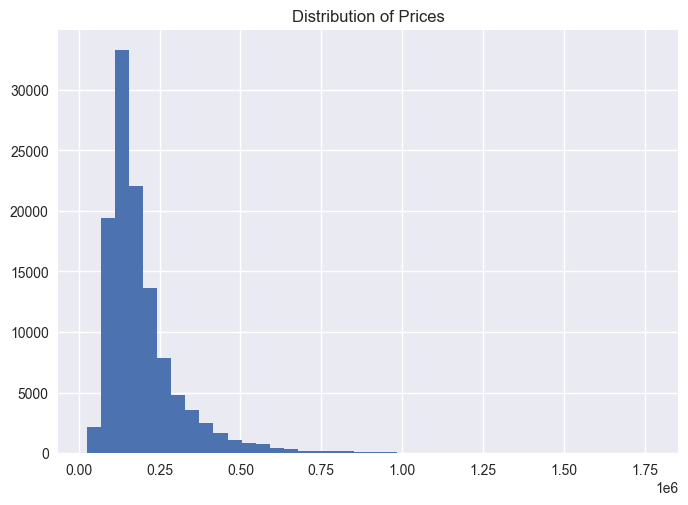

In [654]:
plt.figure()
price_long['Price'].hist(bins=40)
plt.title("Distribution of Prices")
plt.show()


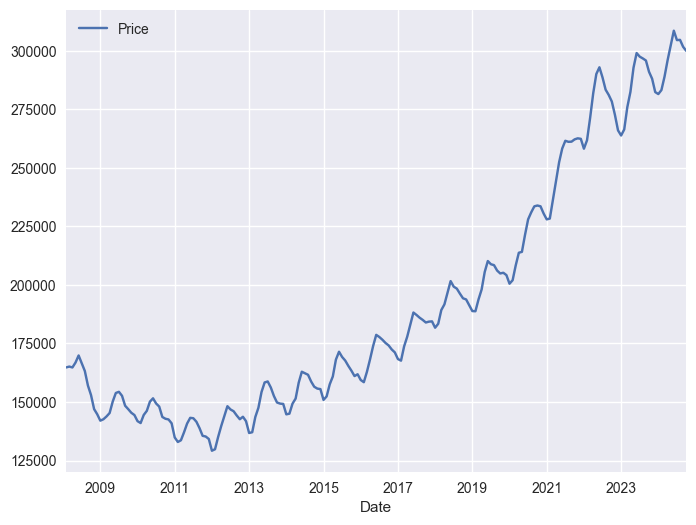

In [655]:
monthly = price_long.groupby('Date')[['Price']].mean()

monthly.plot(subplots=True, figsize=(8,6))
plt.show()

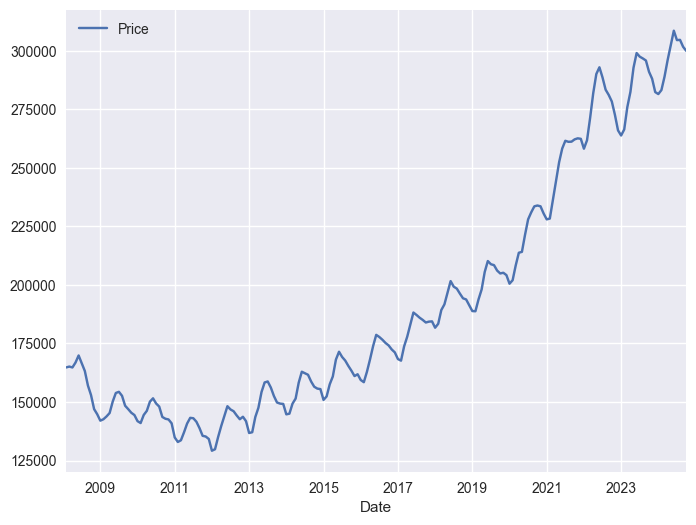

In [656]:
monthly_price = price_long.groupby('Date')[['Price']].mean()

monthly_price.plot(subplots=True, figsize=(8, 6))
plt.show()

# An ascending trend and seasonality are visible if we look at the price alone,
# so we should dive into it with an ACF plot.


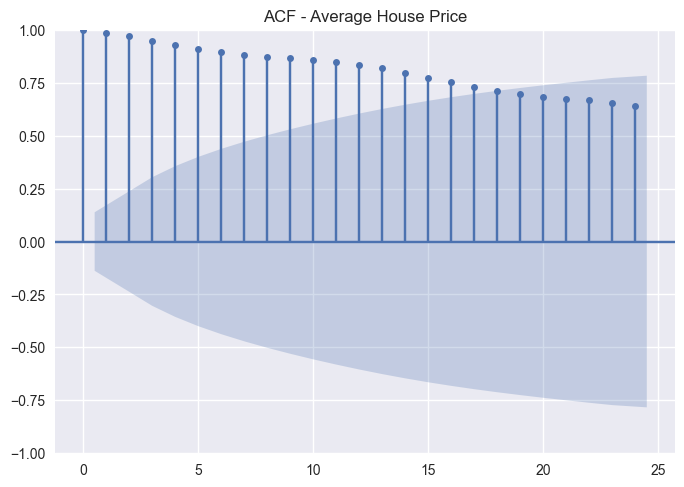

In [657]:
monthly = monthly.asfreq('ME')

plot_acf(monthly['Price'], lags=24)
plt.title("ACF - Average House Price")
plt.show()

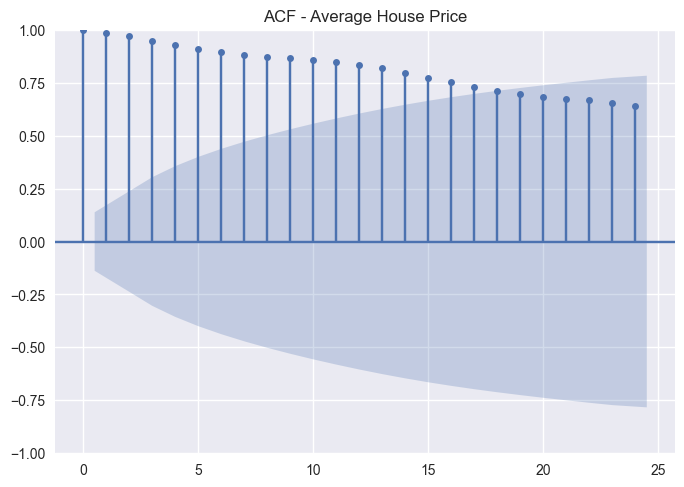

In [658]:
monthly_price = monthly_price.asfreq('ME')

plot_acf(monthly_price['Price'], lags=24)
plt.title("ACF - Average House Price")
plt.show()

The ACF plots reveal a seasonal pattern in the Market Heat Index, with significant autocorrelation at lag 12, indicating annual seasonality. A similar but weaker pattern is observed for house prices, suggesting the presence of yearly seasonal dynamics, although less pronounced than in the heat index.

## 3. Time series analysis

### Making the datasets time series

In [659]:
# Let's take a look at what states we have, and how many records per state we have

print(price_long['StateName'].value_counts().iloc[:5])
states_names = ['OH', 'NC', 'CA', 'TX', 'PA']

StateName
NC    6046
CA    6030
OH    5864
TX    5321
FL    5144
Name: count, dtype: int64


In [660]:
price_long_filtered = price_long[price_long['StateName'].isin(states_names)].copy()
price_long_filtered.head()

heat_long_filtered = heat_long[heat_long['StateName'].isin(states_names)].copy()

price_ts = price_long_filtered.pivot_table(
    index='Date',
    columns='StateName',
    aggfunc='median',
    values='Price'
)
heat_ts = heat_long_filtered.pivot_table(
    index='Date',
    columns='StateName',
    aggfunc='mean',
    values='Heat'
)

price_ts = price_ts.asfreq('ME')
heat_ts = heat_ts.asfreq('ME')


### Time series analysis on Price

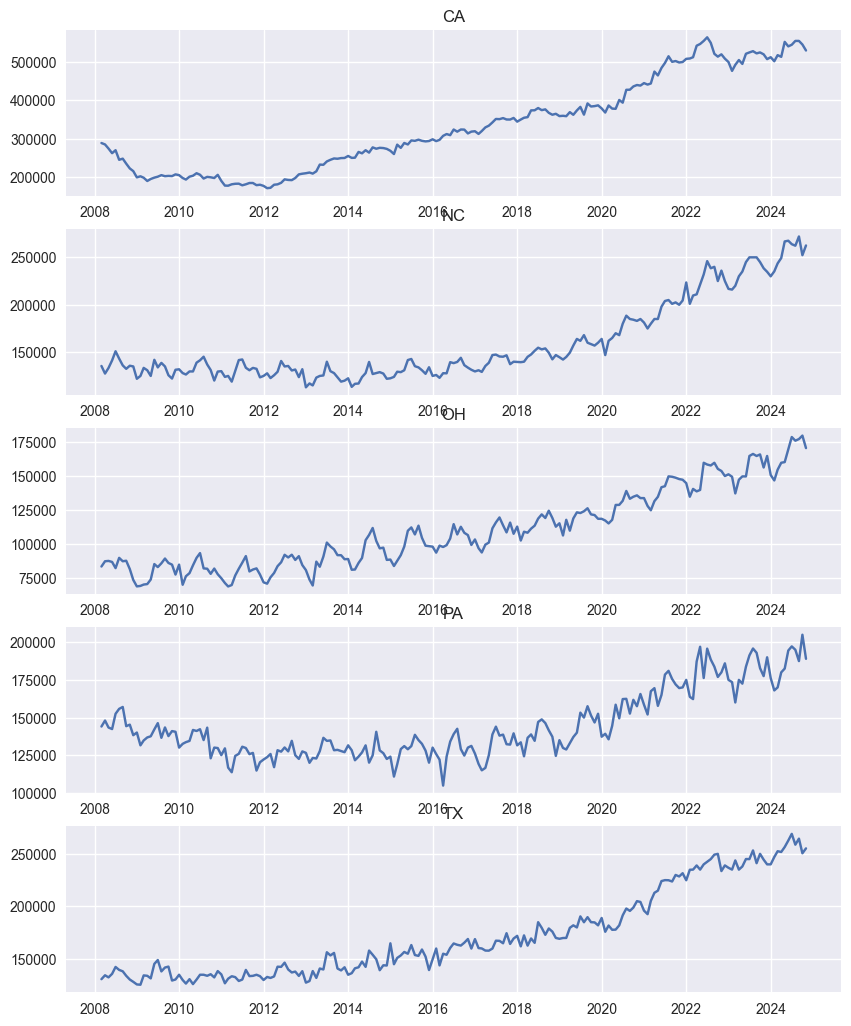

In [661]:
n = len(price_ts.columns)
fig, ax = plt.subplots(n, 1, figsize=(10, 2.5 * n))

for i, col in enumerate(price_ts.columns):
    ax[i].plot(price_ts.index, price_ts[col])
    ax[i].set_title(col)


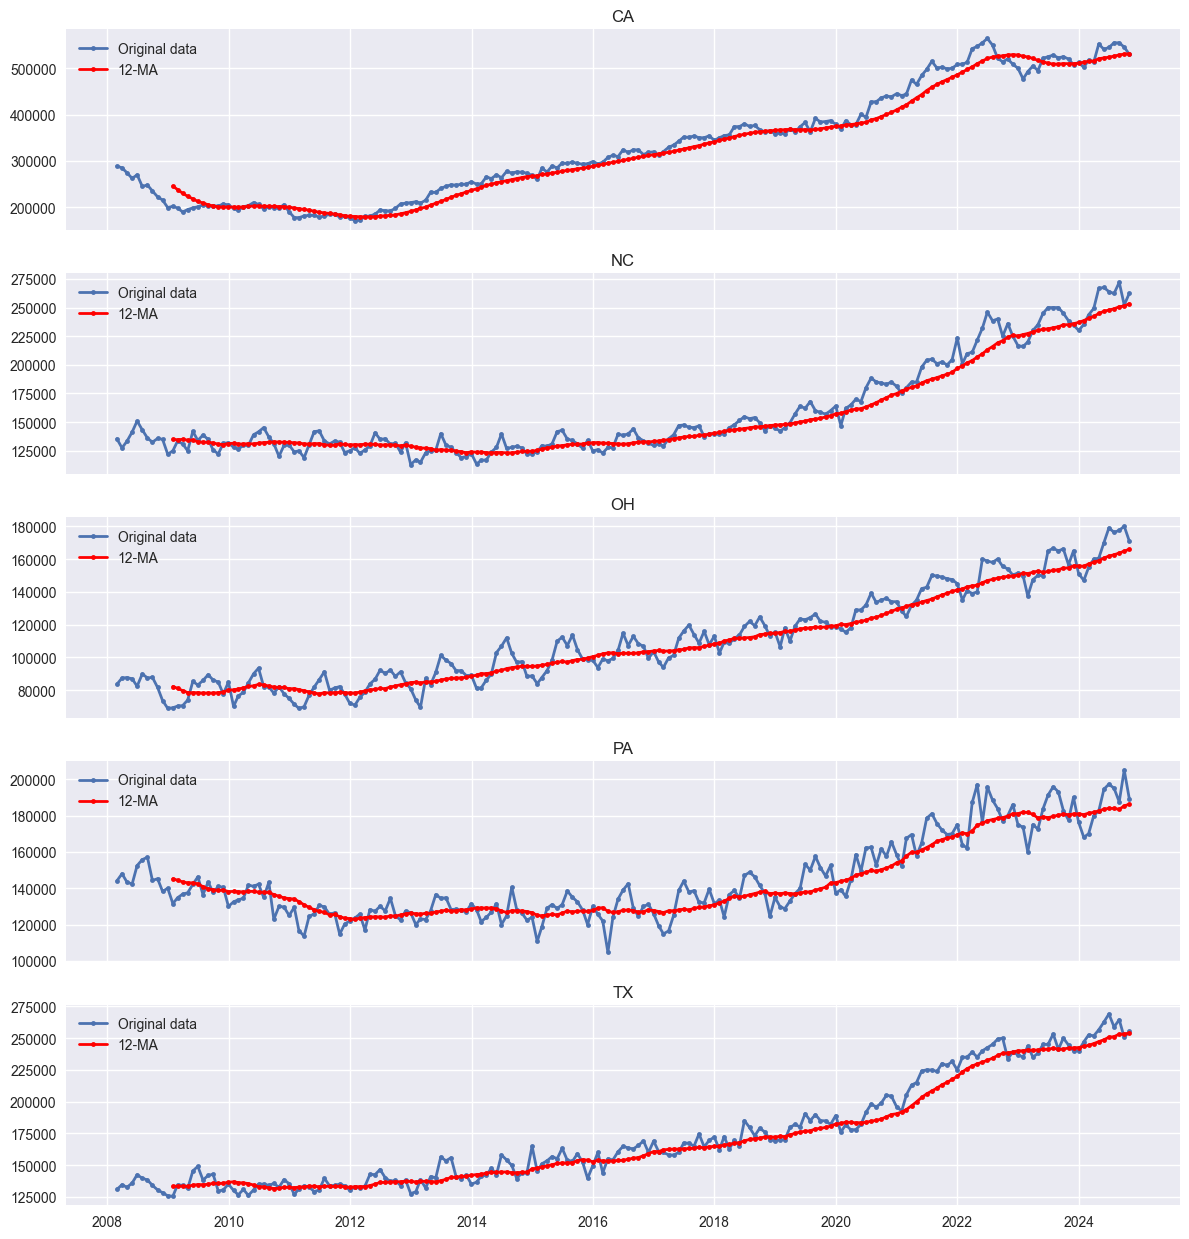

In [662]:
ma12 = price_ts.rolling(12).mean()

n = len(price_ts.columns)
fig, ax = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=True)

for i, col in enumerate(price_ts.columns):
    ax[i].plot(price_ts.index, price_ts[col], label = 'Original data', linewidth=2, marker = '.')
    ax[i].plot(ma12.index, ma12[col],'r-' ,label = '12-MA', linewidth=2, marker = '.')
    ax[i].set_title(col)
    ax[i].legend()

plt.tight_layout()
plt.show()

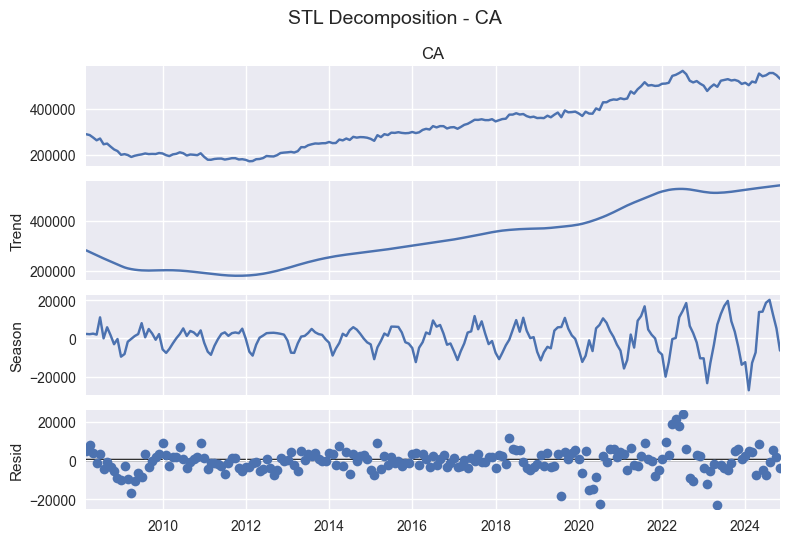

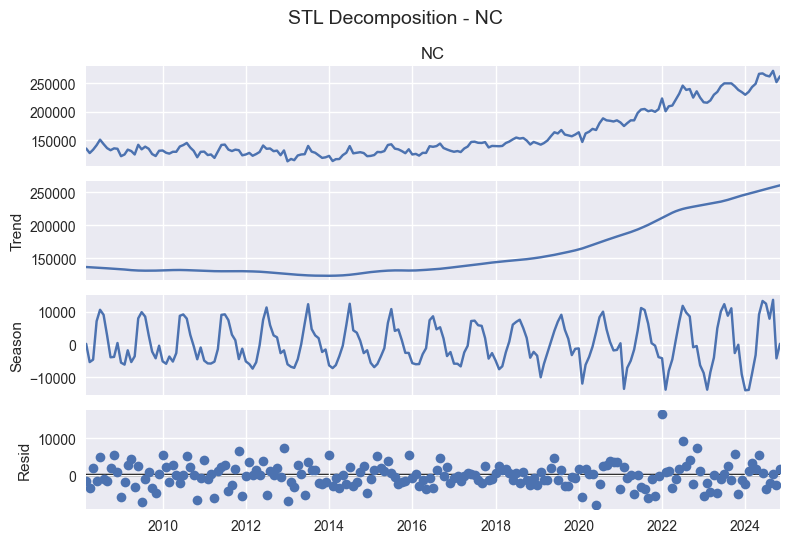

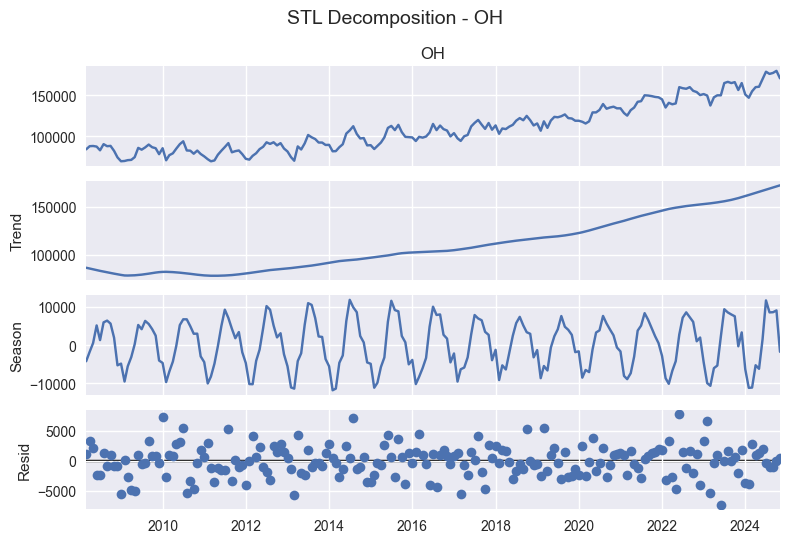

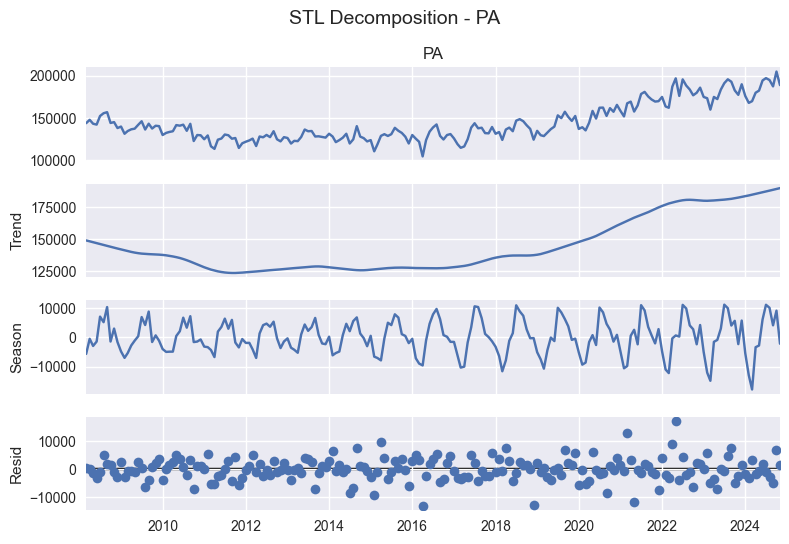

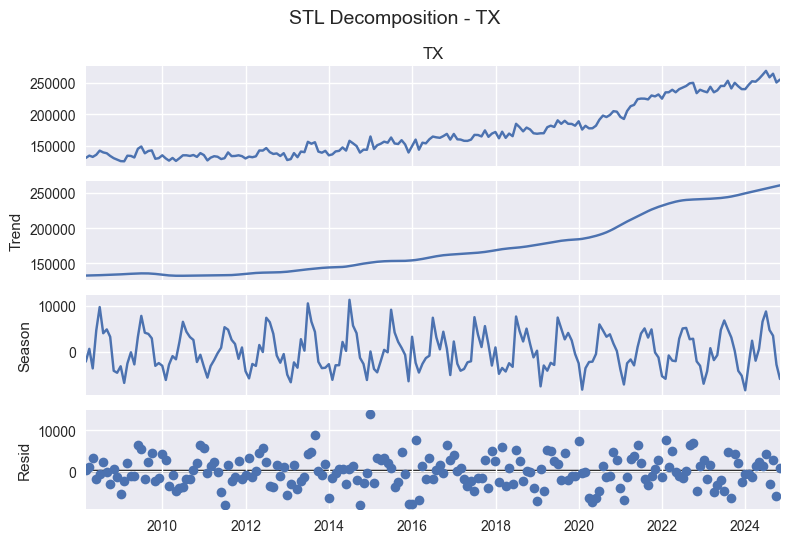

In [663]:
for state in price_ts.columns:
    stl = STL(price_ts[state], period=12)
    result = stl.fit()
    
    fig = result.plot()
    fig.suptitle(f"STL Decomposition - {state}", fontsize=14)
    fig.tight_layout()
    plt.show()

We can clearly see a trend an a seasonality

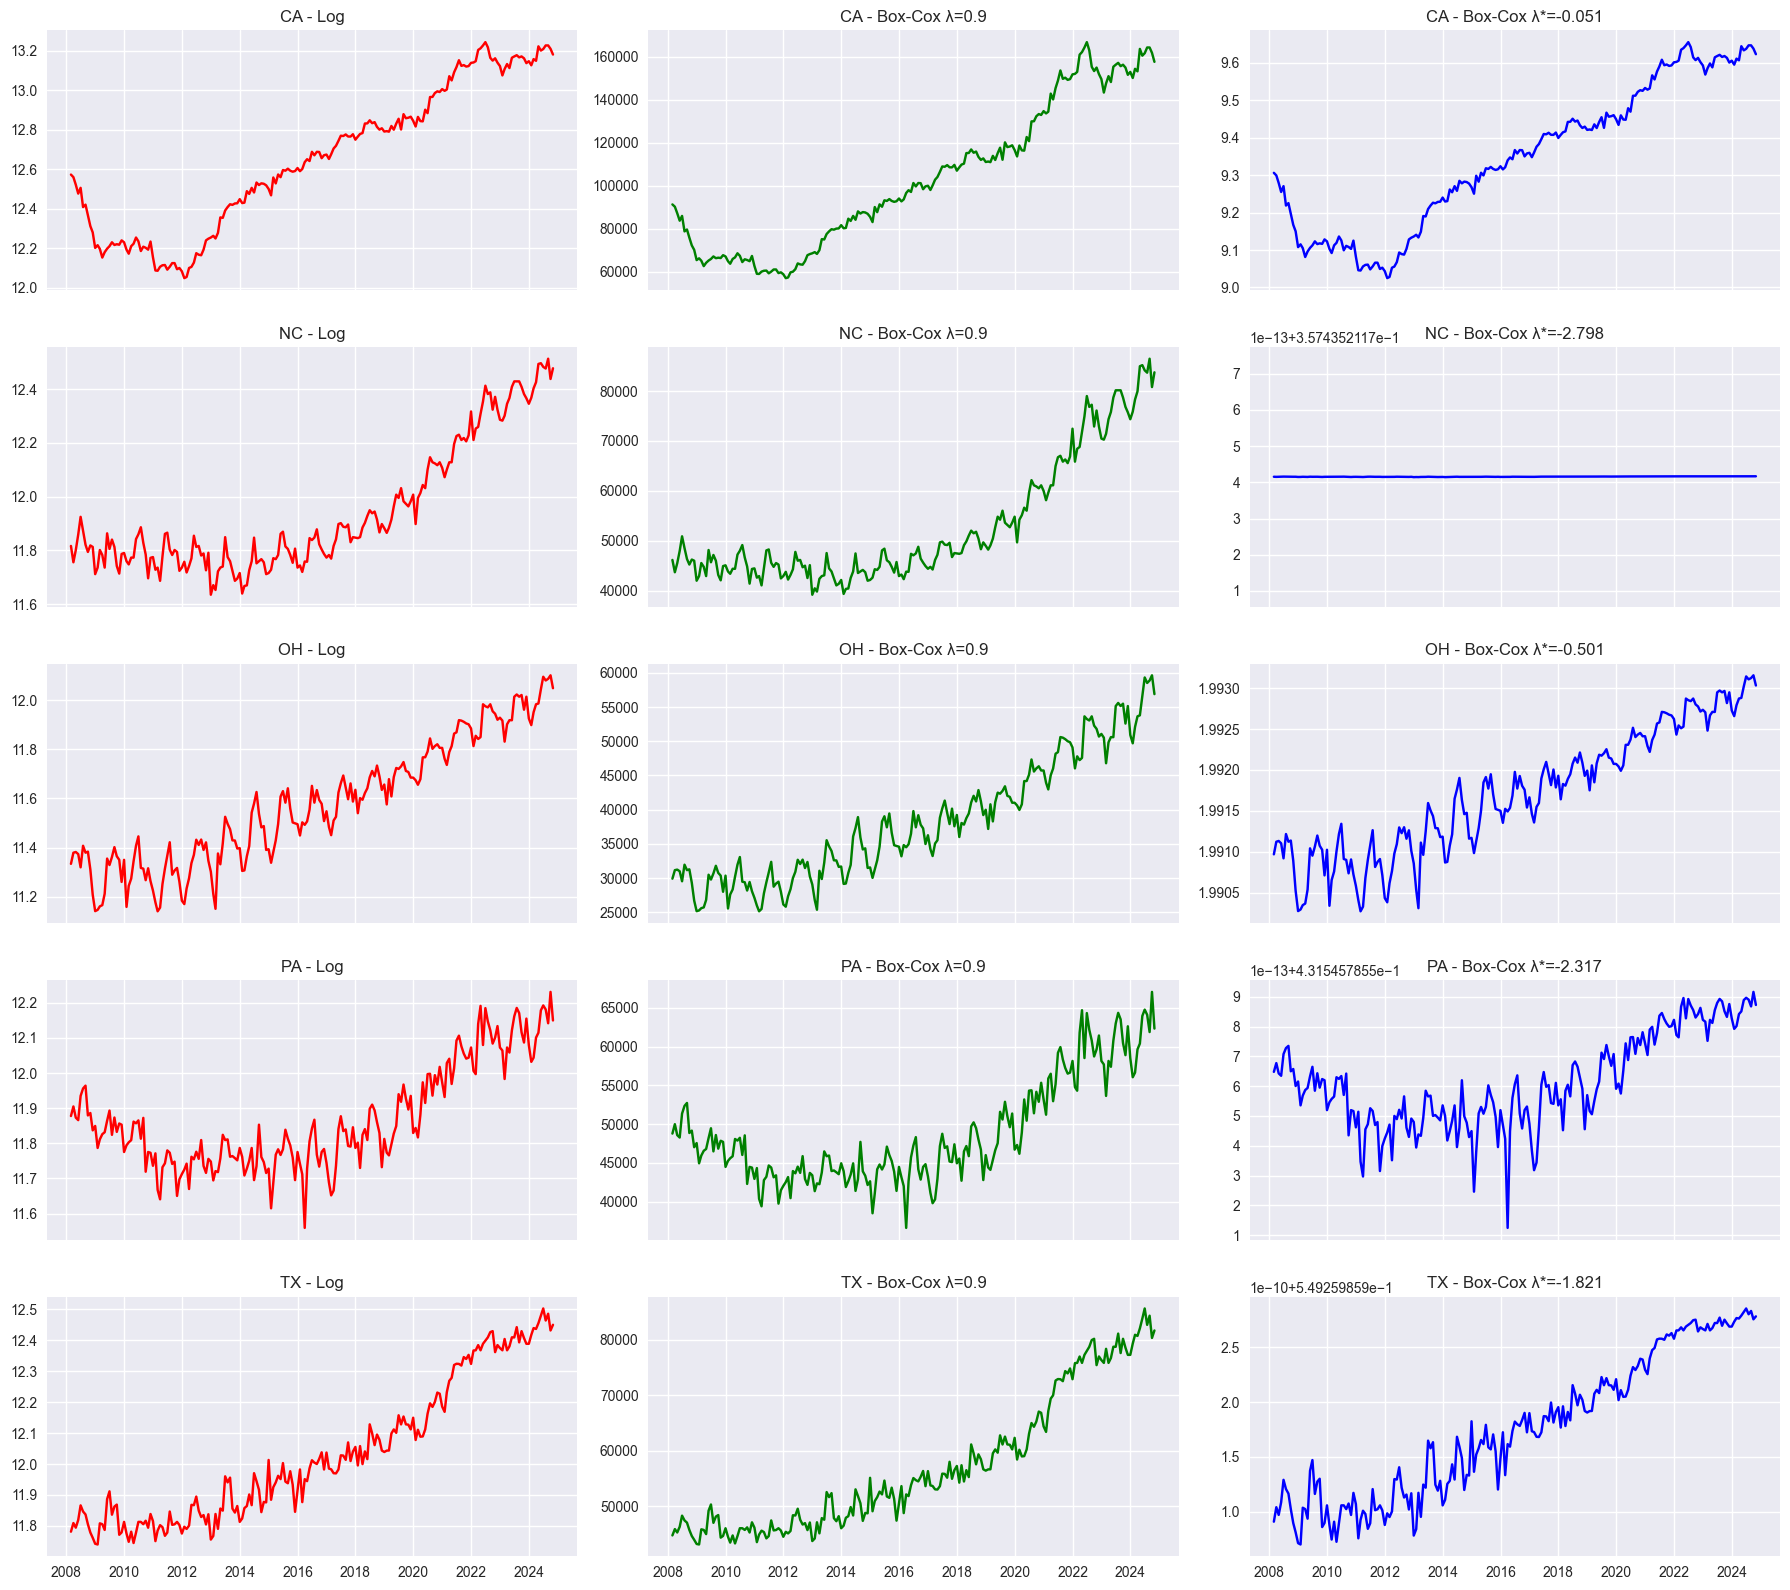

In [664]:

boxcox_lambda = 0.9

n = len(price_ts.columns)
fig, axes = plt.subplots(n, 3, figsize=(18, 3.2 * n), sharex=True)

if n == 1:
    axes = np.array([axes])  # garantisce shape (1,3)

for i, col in enumerate(price_ts.columns):
    ts = price_ts[col]

    min_val = ts.min()
    shift = 1 - min_val if min_val <= 0 else 0
    ts_pos = ts + shift

    ts_log = np.log(ts_pos)
    ts_box_fix = stats.boxcox(ts_pos, lmbda=boxcox_lambda)
    ts_box_auto, opt_lambda = stats.boxcox(ts_pos)

    axes[i, 0].plot(ts.index, ts_log, 'r')
    axes[i, 0].set_title(f"{col} - Log")

    axes[i, 1].plot(ts.index, ts_box_fix, 'g')
    axes[i, 1].set_title(f"{col} - Box-Cox λ={boxcox_lambda}")

    axes[i, 2].plot(ts.index, ts_box_auto, 'b')
    axes[i, 2].set_title(f"{col} - Box-Cox λ*={opt_lambda:.3f}")

plt.tight_layout()
plt.show()


## 4. Is there any association with the market heat index?

In [665]:
# Cutting the dataset
price_reduced_ts = price_ts.loc[
    (price_ts.index >= heat_ts.index.min()) &
    (price_ts.index <= heat_ts.index.max())
]

# Last value missing on the price_ts ds
heat_ts = heat_ts.iloc[:-1]

StateName,CA,NC,OH,PA,TX
Date,,,,,
2018-01-31,54.852941,19.162162,18.136364,13.312500,39.809524
2018-02-28,52.939394,19.351351,20.818182,13.838710,40.306452
2018-03-31,54.323529,23.189189,27.045455,18.781250,43.163934
2018-04-30,57.060606,27.108108,31.340909,22.000000,45.365079
2018-05-31,57.636364,29.486486,33.111111,25.636364,47.129032
...,...,...,...,...,...
2024-06-30,59.147059,43.081081,62.217391,62.942857,42.211268
2024-07-31,55.323529,42.000000,56.652174,59.342857,40.535211
2024-08-31,53.205882,37.756757,51.543478,55.685714,38.873239


StateName,CA,NC,OH,PA,TX
Date,,,,,
2018-01-31,350000.0,139500.0,102750.0,133500.0,162000.0
2018-02-28,354625.0,140000.0,109250.0,124225.0,172447.0
2018-03-31,356250.0,145125.0,108516.5,136500.0,162704.0
2018-04-30,373875.0,147627.5,111500.0,138750.0,169500.0
2018-05-31,374125.0,151500.0,113700.0,134500.0,165346.0
...,...,...,...,...,...
2024-06-30,545000.0,263875.0,178950.0,197250.0,269000.0
2024-07-31,555000.0,262250.0,176250.0,195000.0,258725.0
2024-08-31,555000.0,272000.0,177450.0,187500.0,264456.5


(82,)
(82,)
(82,)
(82,)
(82,)
(82,)
(82,)
(82,)
(82,)
(82,)


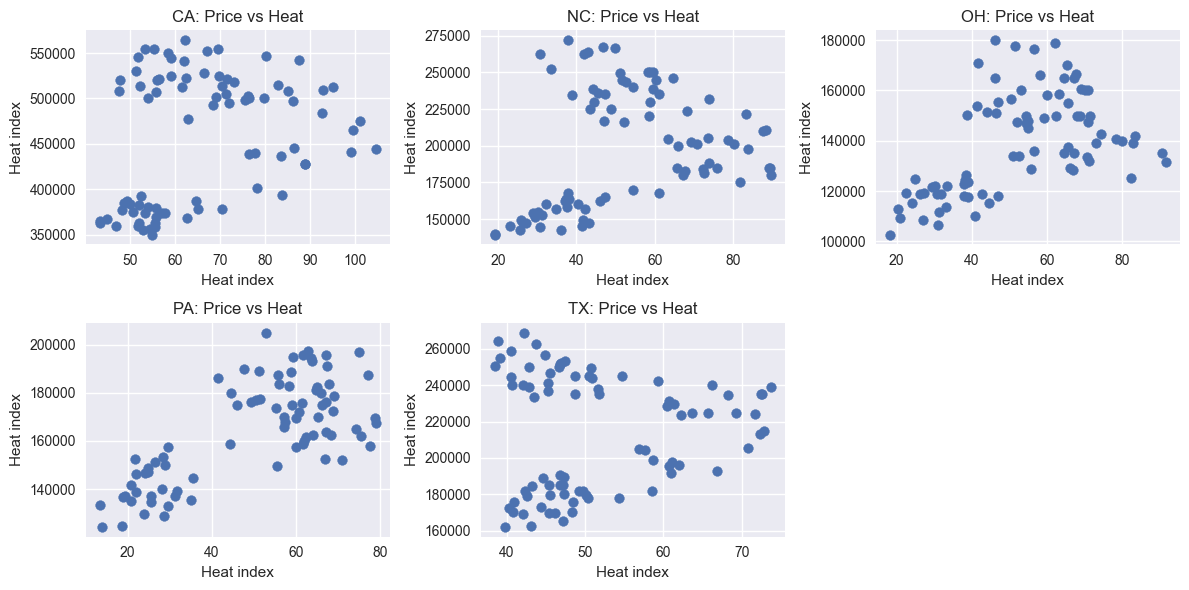

In [666]:
display(heat_ts)
display(price_reduced_ts)



# fig, axes = plt.subplots(2, 3, figsize=(12, 6))
# axes = axes.flatten()

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, state in enumerate(price_reduced_ts.columns):
    print(heat_ts[state].shape)
    print(price_reduced_ts[state].shape)
    axes[i].scatter(heat_ts[state], price_reduced_ts[state])
    axes[i].set_title(f"{state}: Price vs Heat")
    axes[i].set_xlabel('Heat index')
    axes[i].set_ylabel('Heat index')

axes[5].axis('off')
plt.tight_layout()
# plt.tight_layout()
# plt.show()


In [667]:
for state in price_reduced_ts.columns:
    corr = price_reduced_ts[state].corr(heat_ts[state])
    print(f"{state}: {corr:.3f}")

CA: 0.300
NC: 0.300
OH: 0.505
PA: 0.720
TX: 0.078


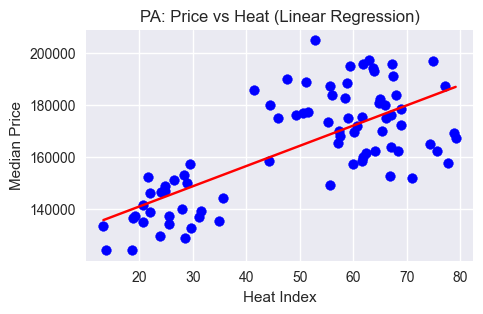

In [668]:
# Having strong correlation on PA, we'll see how a linear regression fits

df = pd.concat([heat_ts['PA'], price_reduced_ts['PA']], axis=1).dropna()
X = df.iloc[:, 0].values.reshape(-1, 1)
y = df.iloc[:, 1].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)
yfit = lin_reg.predict(X)

order = np.argsort(X[:, 0])
plt.figure(figsize=(5, 3))
plt.scatter(X, y, color='blue')
plt.plot(X[order], yfit[order], 'r-')
plt.xlabel('Heat Index')
plt.ylabel('Median Price')
plt.title('PA: Price vs Heat (Linear Regression)')
plt.show()

We conlcude that the only state having a correlation between _heat index_ and _price_ is Pennsylvania (PA)

## 5. Forecast

In [669]:
display(price_reduced_ts.head())
display(heat_ts.head())

StateName,CA,NC,OH,PA,TX
Date,,,,,
2018-01-31,350000.0,139500.0,102750.0,133500.0,162000.0
2018-02-28,354625.0,140000.0,109250.0,124225.0,172447.0
2018-03-31,356250.0,145125.0,108516.5,136500.0,162704.0
2018-04-30,373875.0,147627.5,111500.0,138750.0,169500.0
2018-05-31,374125.0,151500.0,113700.0,134500.0,165346.0


StateName,CA,NC,OH,PA,TX
Date,,,,,
2018-01-31,54.852941,19.162162,18.136364,13.312500,39.809524
2018-02-28,52.939394,19.351351,20.818182,13.838710,40.306452
2018-03-31,54.323529,23.189189,27.045455,18.781250,43.163934
2018-04-30,57.060606,27.108108,31.340909,22.000000,45.365079
2018-05-31,57.636364,29.486486,33.111111,25.636364,47.129032


In [670]:
state = 'PA'

train = price_ts.loc[:'2021-12-31', state]
test  = price_ts.loc['2022-01-31':, state]

print("Train length:", len(train))
print("Test length:", len(test))
print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

Train length: 167
Test length: 34
Train range: 2008-02-29 00:00:00 to 2021-12-31 00:00:00
Test range: 2022-01-31 00:00:00 to 2024-10-31 00:00:00


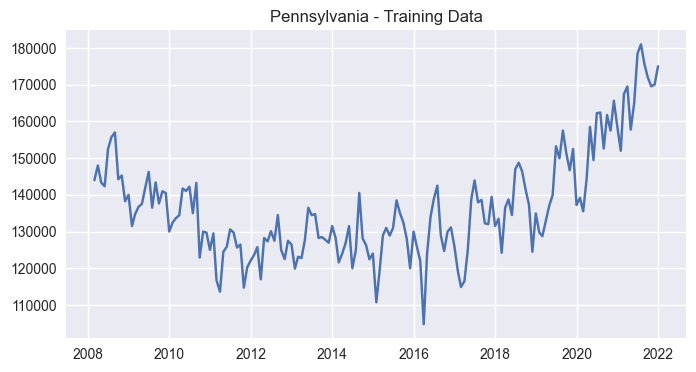

In [671]:
plt.figure(figsize=(8,4))
plt.plot(train)
plt.title("Pennsylvania - Training Data")
plt.show()

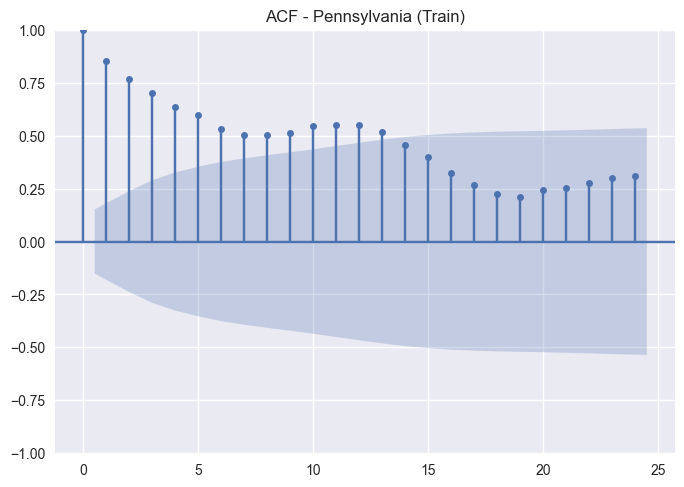

In [672]:
plot_acf(train, lags=24)
plt.title("ACF - Pennsylvania (Train)")
plt.show()

The ACF plot of the Pennsylvania training series exhibits a slow decay, indicating strong persistence and suggesting the presence of a trend component. Moreover, a clear spike at lag 12 confirms the existence of annual seasonality in house prices. These features imply that the series is not stationary and that both trend and seasonal components should be considered when specifying the forecasting model.

In [673]:
df_train = train.to_frame(name='Price')
df_train['t'] = np.arange(len(df_train))
df_train['Month'] = df_train.index.month

X_train = pd.get_dummies(df_train[['t', 'Month']], columns=['Month'], drop_first=True)
X_train = sm.add_constant(X_train).astype(float)

model_seasonal = sm.OLS(df_train['Price'].astype(float), X_train).fit()
print(model_seasonal.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     5.568
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           7.16e-08
Time:                        14:35:18   Log-Likelihood:                -1805.6
No. Observations:                 167   AIC:                             3637.
Df Residuals:                     154   BIC:                             3678.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.182e+05   3848.997     30.706      0.0

The regression results confirm the presence of a significant positive trend and seasonal effects, particularly during summer months. However, the relatively low R² (0.30) suggests that trend and seasonality alone do not fully explain price dynamics.

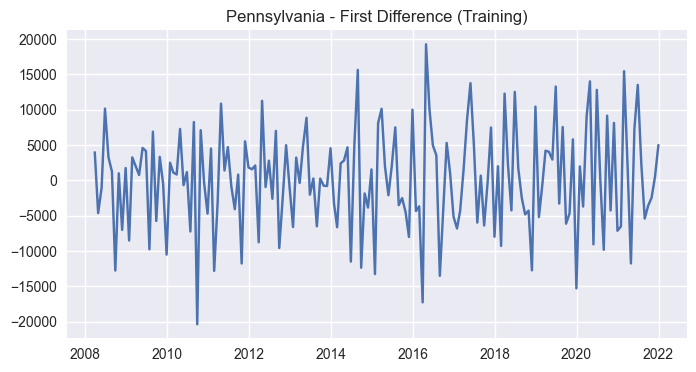

In [674]:
train_diff = train.diff().dropna()

plt.figure(figsize=(8,4))
plt.plot(train_diff)
plt.title("Pennsylvania - First Difference (Training)")
plt.show()

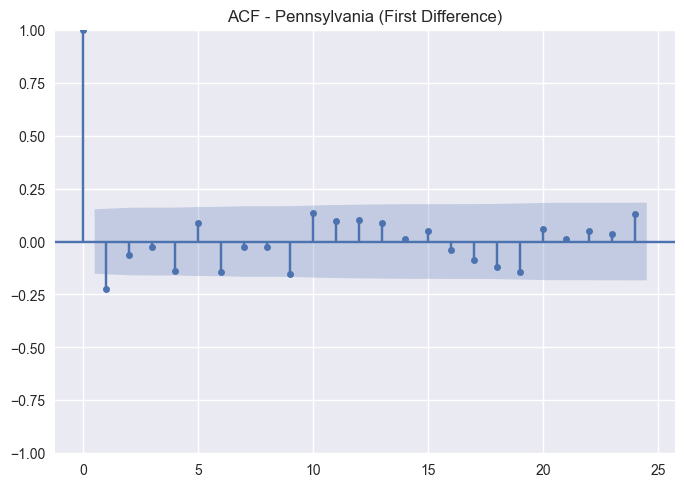

In [675]:
plot_acf(train_diff, lags=24)
plt.title("ACF - Pennsylvania (First Difference)")
plt.show()

After first differencing, the series oscillates around zero and appears visually stationary. The ACF shows a significant negative spike at lag 1, while all other autocorrelations lie within the confidence bounds. This suggests that the differenced series can be adequately modeled using a simple AR(1) structure, implying that an ARIMA(1,1,0) specification may be appropriate for forecasting.

In [676]:
model_arima = ARIMA(train, order=(1,1,0))
results_arima = model_arima.fit()

print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                     PA   No. Observations:                  167
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1708.457
Date:                Sun, 22 Feb 2026   AIC                           3420.914
Time:                        14:35:18   BIC                           3427.138
Sample:                    02-29-2008   HQIC                          3423.440
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0465      0.030     -1.564      0.118      -0.105       0.012
sigma2      4.894e+07   8.62e-12   5.68e+18      0.000    4.89e+07    4.89e+07
Ljung-Box (L1) (Q):                   5.71   Jarque-

In [677]:
model_rw = ARIMA(train, order=(0,1,0))
results_rw = model_rw.fit()

print(results_rw.summary())

                               SARIMAX Results                                
Dep. Variable:                     PA   No. Observations:                  167
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1708.996
Date:                Sun, 22 Feb 2026   AIC                           3419.993
Time:                        14:35:18   BIC                           3423.105
Sample:                    02-29-2008   HQIC                          3421.256
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.095e+07   5.72e+06      8.912      0.000    3.97e+07    6.22e+07
Ljung-Box (L1) (Q):                   8.32   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.00   Pr

In [678]:
forecast_rw = results_rw.get_forecast(steps=len(test))
forecast_mean_rw = forecast_rw.predicted_mean

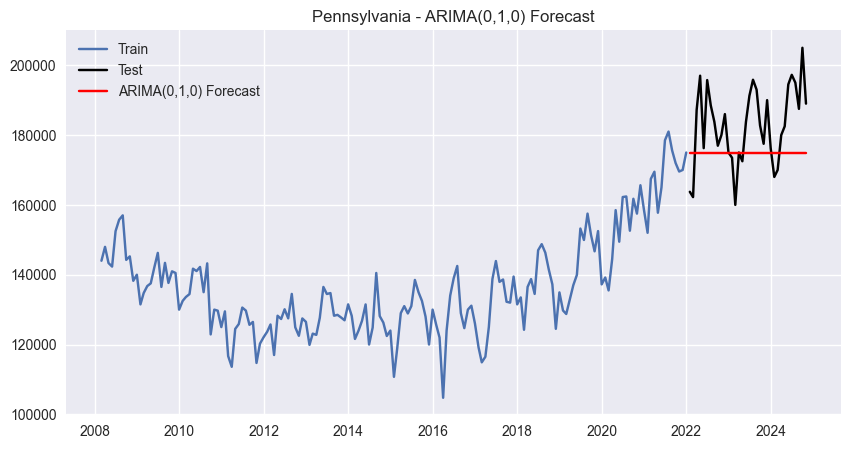

In [679]:
plt.figure(figsize=(10,5))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color='black')
plt.plot(test.index, forecast_mean_rw, label="ARIMA(0,1,0) Forecast", color='red')

plt.legend()
plt.title("Pennsylvania - ARIMA(0,1,0) Forecast")
plt.show()

In [680]:
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae  = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean)/test))*100

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 13364.295858522351
MAE: 10956.558823529413
MAPE: 5.8497671287738395
